# Construcción de Tipologías: Clústers

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

## Reducción de dimensionalidad: PCA

In [3]:
from pyspark.ml.feature import VectorAssembler

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','Horario','LogD'],
    outputCol='features')

bd6 = a1.transform(bd5)

In [4]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
scalerModel = scaler.fit(bd6)
bd6std = scalerModel.transform(bd6)

pca2=PCA(k=2,inputCol='scaledFeatures',outputCol='pca_scaledfeatures')
model2=pca2.fit(bd6std)
bd6pca2=model2.transform(bd6std)


## Clústers - K-Means

In [5]:
from pyspark.ml.clustering import KMeans

#4 clústers
kmeans=KMeans(k=4,seed=123,featuresCol="pca_scaledfeatures",maxIter=10, predictionCol="Cluster")
model3=kmeans.fit(bd6pca2)

bd6Kmeans = model3.transform(bd6pca2)

In [6]:
bd6Kmeans.select('pca_scaledfeatures','Cluster').show()

+--------------------+-------+
|  pca_scaledfeatures|Cluster|
+--------------------+-------+
|[1.25667411910508...|      2|
|[1.23672540371479...|      2|
|[1.24059964059000...|      2|
|[1.23917988807288...|      2|
|[1.27813884218153...|      2|
|[1.26480761353166...|      2|
|[1.25677037427412...|      2|
|[1.25005663236466...|      2|
|[1.24466638780329...|      2|
|[1.23795264589383...|      2|
|[1.22859190928821...|      2|
|[1.27284485278920...|      2|
|[1.26877810557591...|      2|
|[1.25809387162220...|      2|
|[1.25005663236466...|      2|
|[1.24334289045521...|      2|
|[1.21942368302067...|      2|
|[1.20741595171888...|      2|
|[1.25431588991603...|      2|
|[1.23833766656999...|      2|
+--------------------+-------+
only showing top 20 rows



In [7]:
bd6Kmeans.groupBy('Cluster').count().show()

+-------+-----+
|Cluster|count|
+-------+-----+
|      0| 8469|
|      1| 6850|
|      2| 6886|
|      3| 8261|
+-------+-----+



## Caracterización de los Clústers

In [8]:
centers = model3.clusterCenters()
centers

[array([ 1.59974354, -0.76115474]),
 array([-1.31833824, -1.11838545]),
 array([ 0.51410457,  1.52214226]),
 array([-0.97800182,  0.45174597])]

In [9]:
sqlContext.registerDataFrameAsTable(bd6Kmeans, "bd6Kmeans")

g3 = sqlContext.sql("select Cluster, count(*) as n, \
               avg(DepDelay) as DepDelay, \
               avg(Distance) as Distance, \
               avg(DayOfWeek) as DayOfWeek, \
               avg(CRSDepTime) as CRSDepTime, \
               avg(Horario) as Horario, \
               avg(LogD) as LogD \
               from bd6Kmeans group by Cluster")
g3.toPandas()

,Cluster,n,DepDelay,Distance,DayOfWeek,CRSDepTime,Horario,LogD
0,0,8469,18.189751,1663.447514,3.996694,1383.349510,2.596529,3.214821
1,1,6850,34.011533,609.716496,4.055182,1807.292847,3.900438,2.735547
2,2,6886,3.564043,853.089893,3.915045,728.639413,1.351292,2.888984
3,3,8261,13.686721,518.818303,4.007142,1402.382520,2.342331,2.671195


## Representación Gráfica

In [10]:
#Extraemos las componentes

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

p1=udf(lambda v:float(v[0]),FloatType())
p2=udf(lambda v:float(v[1]),FloatType())

bd6Kmeans=bd6Kmeans.withColumn('pca1',p1('pca_scaledfeatures')).withColumn('pca2',p2('pca_scaledfeatures'))

pdf6 = bd6Kmeans.sample(False, 0.1, 0).select('pca1','pca2','Cluster').toPandas()
pdf6

,pca1,pca2,Cluster
0,1.256770,0.657562,2
1,0.335176,-1.505498,0
2,0.300862,-1.648970,0
3,0.373847,-1.393456,0
4,0.329854,-1.518077,0
5,0.380724,-1.395389,0
6,-1.585298,1.877169,3
7,-1.578488,1.879198,3
8,-2.663863,-0.671969,1
9,-2.747147,-1.003021,1


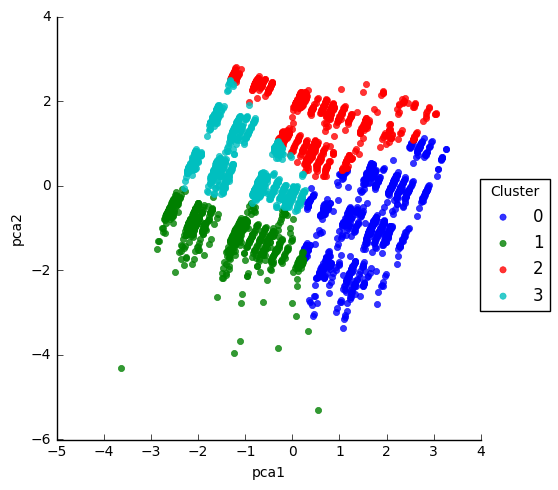

In [12]:
import seaborn as sns
%matplotlib inline

sns.lmplot(x="pca1", y="pca2", hue="Cluster", fit_reg=False, data=pdf6)